In [21]:
# libraries
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
# test data 
# wavelength database:
# dictionary of wavelengths and their corresponding intensities
# why all these zero intensities? And why do we do nothing with the intensities?
NEON_WAVELN = {
    532.640 : 20,
    533.078 : 60,
    533.331 : 0,
    533.571 : 0, 
    534.109 : 100,
    534.328 : 60,
    534.920 : 0,
    535.516 : 0,
    535.542 : 0,
    535.802 : 0,
    536.001 : 0,
    536.042 : 0,
    536.223 : 0,
    537.231 : 0,
    537.498 : 0,
    538.325 : 0,
    540.056 : 200,
    541.265 : 0,
    541.856 : 0,
}

# spectral fit output:
# array of wavelengths of spectral lines in pixels
spectral_lines = np.array([
    22.181795919847822,
    41.140395614525275,
    144.26273501671918,
    186.4979599536216,
    292.1601184580567,
    335.21179409990134,
    377.61005873042376,
    414.14821455025987,
    445.4639986187941,
])
print(len(NEON_WAVELN))

19


TypeError: unhashable type: 'slice'

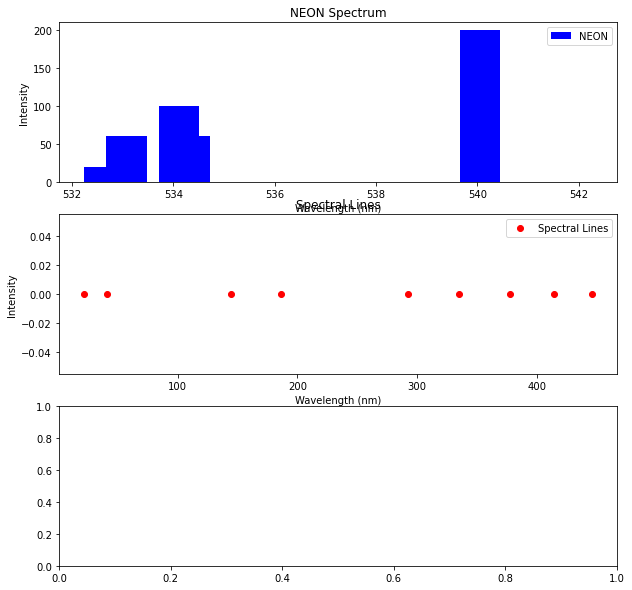

In [43]:
# visualizing the data
fig, ax = plt.subplots(figsize=(10, 10), nrows=3, ncols=1)

ax[0].bar(NEON_WAVELN.keys(), NEON_WAVELN.values(), color='blue', label='NEON')
ax[0].set_title('NEON Spectrum')
ax[0].set_xlabel('Wavelength (nm)')
ax[0].set_ylabel('Intensity')
ax[0].legend()

ax[1].scatter(spectral_lines, np.zeros(len(spectral_lines)), color='red', label='Spectral Lines')
ax[1].set_title('Spectral Lines')
ax[1].set_xlabel('Wavelength (nm)')
ax[1].set_ylabel('Intensity')
ax[1].legend()

for i in range(len(spectral_lines)):
    plt.scatter(spectral_lines, NEON_WAVELN[0+i:len(spectral_lines)+i], color='r')

In [ ]:
def get_dispersion_hint():
    wavelength = 532 # nm (wavelength of the laser?)
    focal_length = 1000 # mm
    groove_density = 1800 # gr/mm
    d = 1 / groove_density # mm --> why not used??
    m = 1 # diffraction_order --> one, so left out
    
    blaze_angle = 28.6 # deg
    # Littrow configuration

    linear_disp = wavelength / (2 * focal_length * np.tan(blaze_angle / 180 * np.pi)) # nm/mm--> focal length in mm, rest in nm??
    
    # pixel_size = 16 # um --> hmm.. should be nm??
    pixel_size = 16000 #nm 
    fiber_optic_taper = 1.48 # units?
    ccd_size = 512 # pixels
    
    # conversion to nm/pixel
    dispersion_hint = linear_disp * pixel_size * fiber_optic_taper / 1000 # nm/pixel
    spectral_range = dispersion_hint * ccd_size # nm  --> you would want this to be larger than the spectral range of the NEON spectrum
    print(f"Dispersion hint: {dispersion_hint:.2f} nm/pixel")
    return dispersion_hint

In [24]:
def combine(a, b):
    """
    Combines two 1D arrays into a 2D array of all possible pairs.

    Parameters:
    a (numpy.ndarray): A 1D numpy array.
    b (numpy.ndarray): A 1D numpy array.

    Returns:
    numpy.ndarray: A 2D numpy array where each row is a pair from the input arrays.
    """
    return np.array(np.meshgrid(a[:, np.newaxis], b[np.newaxis, :])).T.reshape(-1, 2)

In [25]:
is_sorted = lambda a: np.all(a[:-1] <= a[1:])

In [ ]:
def find_wl_match(spl, wldb, _disp=None):
    """
    Find spectral database offset for given peak results.
    spl: spectral lines
    wldb: wavelength database
    _disp: dispersion hint
    """
   
    # convert peak database into numpy array
    wldba = np.asarray(sorted(wldb))
    
    # delete lines from database that are closer than minimum resolution
    # WLN_RES_FILTER_NM = 0
    # wldba = np.delete(wldba, 1 + np.nonzero(np.abs(np.diff(wldba)) < WLN_RES_FILTER_NM)[0])
    
    # # calculate preliminary dispersion based on the closest (Ne) peak doublet
    # # (which should be in the spectrum)
    # if not _disp:
    #     # _disp =1
    #     _disp = np.nanmin(np.diff(wldba)) / np.nanmin(np.diff(spl))

    # create a combined array of found peaks versus peak database
    splma = combine(spl, wldba) # splma = spectral lines match array (every peak with every wavelength)
    
    # compare relative wavelength positions
    splmd = np.full((len(spl), len(wldba)), np.nan)

    
    for i in range(len(spl)):
        sel = splma[i::len(wldba)+1] # strictly increasing subarrays (but not all!!)
        
        if not is_sorted(sel[:, 1]):
            sel = sel[:np.nanargmax(sel[:, 1]) + 1]        
        
        if len(sel) > 1:
            sub = np.abs(
                np.diff(_disp * sel[:, 0]) - np.diff(sel[:, 1])) 
            # difference between the sum of wavelengths and the sum of intensities 
            # already multiplied by theoretical dispersion
            # both sel[:, 0] and sel[:, 1] are wavelengths [nm], why multiply by dispersion [nm]/[pixel]?
            splmd[i, :len(sub)] = np.roll(sub, i)
    
    wl_oi = int(np.round(np.nanargmin([np.nanmin(
        splmd[i::len(wldba)+1]) for i in range(len(wldba)) 
            if not np.all(np.isnan(splmd[i::len(wldba)+1]))]))) # index of minimal difference 
                                                                # with the theoretical dispersion
    
    # return adapted wavelength database (only the matched wavelengths)
    return wldba[wl_oi:]

Dispersion hint: 11.55 nm/pixel
13 [534.92  535.516 535.542 535.802 536.001 536.042 536.223 537.231 537.498
 538.325 540.056 541.265 541.856]


Text(0, 0.5, 'Neon wavelengths')

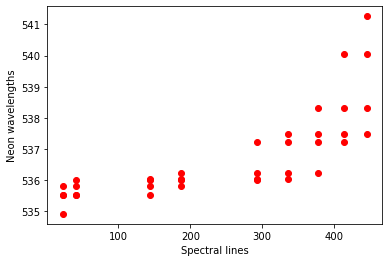

In [ ]:
_disp = get_dispersion_hint()
neon_waveln = find_wl_match(spectral_lines, NEON_WAVELN, _disp)
print(len(neon_waveln), neon_waveln)
# plt.scatter(spectral_lines, neon_waveln, 'o-')
# scatterplot
for i in range(0, abs(len(neon_waveln)- len(spectral_lines))):
    plt.scatter(spectral_lines, neon_waveln[0+i:len(spectral_lines)+i], color='r')
    
# add labels
plt.xlabel('Spectral lines')
plt.ylabel('Neon wavelengths')